In [ ]:
#importing all the libraries required
%matplotlib inline
import tensorflow as tf
import numpy as np
import cv2, os, glob, random
import matplotlib.pyplot as plt
input_shape = (128, 128, 3)
import tensorflow.keras.backend as K
import tensorflow_addons as tfa

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
DATA_DIR = "/content/drive/My Drive/final_cropped/"
X = []
Y = []
k = 0
for i in range(2190):
  X.append(f"/content/drive/My Drive/final_cropped/{i+1}.jpg")
  if i % 6 == 0:
    k += 1
  Y.append(k)

In [ ]:
#splitting into train and test
(x_train, y_train), (x_test, y_test) = (X[:int(0.8*len(X))], Y[:int(0.8*len(Y))]), (X[int(0.8*len(X)):], Y[int(0.8*len(Y)):])
y_train = np.array(y_train)
y_test = np.array(y_test)
print(np.where(y_train == 1))

In [ ]:
#code for plotting the triplets
def plot_triplets(examples):
  for i in range(3):
    plt.subplot(1, 3, 1 + i)
    plt.imshow(np.reshape(examples[i], (128, 128, 3)), cmap='binary')
    plt.xticks([])
    plt.yticks([])
  plt.show()

In [ ]:
#creating the data generator
emb_size = 128
class DataGenerator(tf.keras.utils.Sequence):
  def __init__(self, traindir, labels, batch_size=32):
    self.traindir = traindir
    self.labels = labels
    self.batch_size = batch_size

  def __len__(self):
    return int(np.floor(len(self.traindir) / self.batch_size))

  def __getitem__(self, index):
    while True:
        x = self.create_batch()
        y = np.zeros((self.batch_size, 3*emb_size))
        return x, y

  def create_batch(self):

    x_anchors = np.zeros((self.batch_size, 128, 128, 3))
    x_positives = np.zeros((self.batch_size, 128, 128, 3))
    x_negatives = np.zeros((self.batch_size, 128, 128, 3))

    for i in range(0, self.batch_size):
      random_index = random.randint(0, len(self.traindir) - 1)

      #Anchor image
      x_anchor = cv2.resize(cv2.imread(self.traindir[random_index]), (128, 128))
      # x_anchor = np.expand_dims(x_anchor, axis=2)
      x_anchor = x_anchor.astype('float32')
      x_anchor /= 255.

      y = self.labels[random_index]
      indices_for_pos = np.squeeze(np.where(self.labels == y))
      indices_for_neg = np.squeeze(np.where(self.labels != y))
      
      #Positive image
      x_positive = cv2.resize(cv2.imread(self.traindir[indices_for_pos[random.randint(0, len(indices_for_pos) - 1)]]), (128, 128))
      # x_positive = np.expand_dims(x_positive, axis=2)
      x_positive = x_positive.astype('float32')
      x_positive /= 255.

      #Negative image
      x_negative = cv2.resize(cv2.imread(self.traindir[indices_for_neg[random.randint(0, len(indices_for_neg) - 1)]]), (128, 128))
      # x_negative = np.expand_dims(x_negative, axis=2)
      x_negative = x_negative.astype('float32')
      x_negative /= 255.
      
      x_anchors[i] = x_anchor
      x_positives[i] = x_positive
      x_negatives[i] = x_negative
          
    return [x_anchors, x_positives, x_negatives]



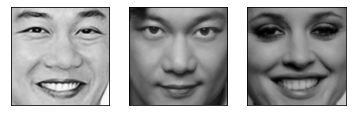

In [ ]:
#testing if the data generator is working
gg = DataGenerator(x_train, y_train, batch_size=1)
plot_triplets(gg.__getitem__(1)[0])

In [ ]:
#creating the embedding model to represent the images into 128dimensional vector
def embedding_model():
  model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(input_shape = input_shape),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(emb_size, activation='relu')                                            
  ])

  # embedding_model.summary()
  # resnet = tf.keras.applications.ResNet50(include_top = False, weights='imagenet', input_shape=(128, 128, 3))
  # for layer in resnet.layers:
  #   layer.trainable = False
  # x = resnet.get_layer('conv5_block3_out').output
  # model_out = tf.keras.layers.Flatten()(x)
  # model_out = tf.keras.layers.Dense(emb_size, activation='relu')(model_out)
  # model = tf.keras.models.Model(inputs=resnet.input, outputs=model_out)

  return model

In [ ]:
def identity_loss(y_true, y_pred):
  return tf.keras.backend.mean(y_pred)

#defining the triplet loss with alpha selected as 0.2

def triplet_loss(x, alpha=0.2):
  # anchor, positive, negative = y_pred[:,:emb_size], y_pred[:,emb_size:2*emb_size], y_pred[:,2*emb_size:]
  anchor, positive, negative = x
  positive_dist = tf.reduce_mean(tf.square(anchor - positive), axis=1)
  negative_dist = tf.reduce_mean(tf.square(anchor - negative), axis=1)
  loss = tf.maximum(positive_dist - negative_dist + alpha, 0.)
  return loss         


In [ ]:
#combining the embedding model and the loss function
def complete_model(base_model):
  input_anchor = tf.keras.layers.Input(shape=input_shape)
  input_positive = tf.keras.layers.Input(shape=input_shape)
  input_negative = tf.keras.layers.Input(shape=input_shape)

  embedding_anchor = base_model(input_anchor)
  embedding_positive = base_model(input_positive)
  embedding_negative = base_model(input_negative)

  # output = tf.keras.layers.concatenate([embedding_anchor, embedding_positive, embedding_negative], axis=1)
  
  # net = tf.keras.models.Model([input_anchor, input_positive, input_negative], output)
  loss = tf.keras.layers.Lambda(triplet_loss)([embedding_anchor, embedding_positive, embedding_negative])


  model = tf.keras.models.Model(inputs=[input_anchor, input_positive, input_negative], outputs=loss)
  model.compile(loss=identity_loss, optimizer='adam')
  return model

In [ ]:
#creating the complete model
epochs = 100
batch_size = 32
steps_per_epoch = 20

train_generator = DataGenerator(x_train, y_train, batch_size=batch_size)
test_generator = DataGenerator(x_test, y_test, batch_size=batch_size)

base_model = embedding_model()
model = complete_model(base_model)
model.summary()

tf.keras.utils.plot_model(model, to_file='model.png')


In [ ]:
#fitting the model
history = model.fit(
    train_generator,
    validation_data = test_generator,     
    epochs=epochs,
    steps_per_epoch=steps_per_epoch,     
    validation_steps=10
)


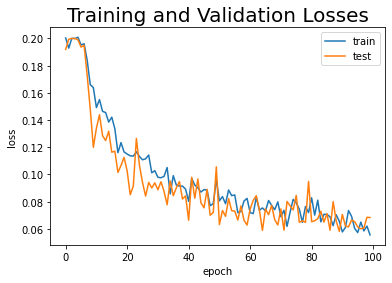

In [ ]:
#plotting the loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training and Validation Losses',size = 20)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.savefig(f"/content/drive/My Drive/OwnModel_epoch{epochs}_batchsize{batch_size}_alpha{0.2}_embsize{emb_size}.png")
plt.show()

In [ ]:
#saving the model
base_model.save("/content/drive/My Drive/own_base_model.h5")
model.save("/content/drive/My Drive/own_complete_network.h5")

In [ ]:
#loading the model
base_model1 = tf.keras.models.load_model("/content/drive/My Drive/own_base_model.h5")


tf.Tensor([0.04650831], shape=(1,), dtype=float32) tf.Tensor([0.27822745], shape=(1,), dtype=float32)
tf.Tensor([False], shape=(1,), dtype=bool)


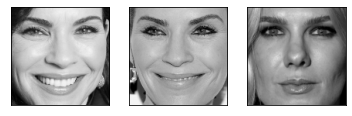

(1, 128)


In [ ]:
#individual prediction
import sklearn.metrics
# for i in range(10):
gg = DataGenerator(x_test, y_test, batch_size=1).__getitem__(1)[0]

img_a = base_model1.predict(gg[0])
img_b = base_model1.predict(gg[1])
img_c = base_model1.predict(gg[2])

positive_dist = tf.reduce_mean(tf.square(img_a - img_b), axis=1)
negative_dist = tf.reduce_mean(tf.square(img_a - img_c), axis=1)
print(positive_dist, negative_dist)
print(positive_dist > negative_dist)
plot_triplets(gg)
print(img_a.shape)

In [ ]:
img_a = np.squeeze(img_a)
img_b = np.squeeze(img_b)
img_c = np.squeeze(img_c)
def findCosineSimilarity(source_representation, test_representation):
 a = np.matmul(np.transpose(source_representation), test_representation)
 b = np.sum(np.multiply(source_representation, source_representation))
 c = np.sum(np.multiply(test_representation, test_representation))
 return 1 - (a / (np.sqrt(b) * np.sqrt(c)))

cosine_similarity = findCosineSimilarity(img_a, img_b)
print("cosine similarity: ",cosine_similarity)
threshold = 0.04
if cosine_similarity < threshold:
 print("verified... they are same person")
else:
 print("unverified! they are not same person!")


cosine similarity:  0.012350976467132568
verified... they are same person


(1, 128, 128, 3)


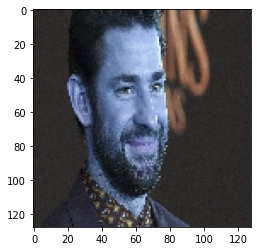

(1, 128, 128, 3)


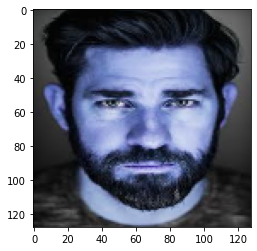

(1, 128, 128, 3)


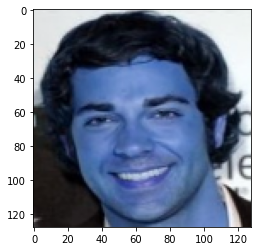

In [ ]:
img1 = cv2.resize(cv2.imread("/content/drive/My Drive/JK1.jpg"), (128, 128))
img1 = np.expand_dims(img1, axis=0)
img1 = img1.astype('float32')
img1 /= 255.
print(img1.shape)
plt.imshow(np.resize(img1, (128, 128, 3)))
plt.show()

img2 = cv2.resize(cv2.imread("/content/drive/My Drive/JK2.jpg"), (128, 128))
img2 = np.expand_dims(img2, axis=0)
img2 = img2.astype('float32')
img2 /= 255.
print(img2.shape)
plt.imshow(np.resize(img2, (128, 128, 3)))
plt.show()

img3 = cv2.resize(cv2.imread("/content/drive/My Drive/JK3.jpg"), (128, 128))
img3 = np.expand_dims(img3, axis=0)
img3 = img3.astype('float32')
img3 /= 255.
print(img3.shape)
plt.imshow(np.resize(img3, (128, 128, 3)))
plt.show()

In [ ]:

first = base_model1.predict(img1)
second = base_model1.predict(img2)
third = base_model1.predict(img3)


positive_dist = tf.reduce_mean(tf.square(first - second), axis=1)
negative_dist = tf.reduce_mean(tf.square(first - third), axis=1)
print(positive_dist, negative_dist)
print(positive_dist > negative_dist)

tf.Tensor([0.36767587], shape=(1,), dtype=float32) tf.Tensor([0.16844821], shape=(1,), dtype=float32)
tf.Tensor([ True], shape=(1,), dtype=bool)
